# GIN Experiment
This notebook will implement the evaluation pipeline with the FID calculation using the GIN

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from tqdm import tqdm
from util import load_graph_list
from util import load_data, load_synth_data, separate_data , load_graph_asS2Vgraph
from models.graphcnn import GraphCNN
from prdc import compute_prdc
from kid_metric import kernel_classifier_distance_and_std_from_activations

criterion = nn.CrossEntropyLoss()

In [2]:
def train(iters_per_epoch, batch_size, model, device, train_graphs, optimizer, epoch):
    model.train()

    total_iters = iters_per_epoch
    pbar = tqdm(range(total_iters), unit='batch')

    loss_accum = 0
    for pos in pbar:
        selected_idx = np.random.permutation(len(train_graphs))[:batch_size]

        batch_graph = [train_graphs[idx] for idx in selected_idx]
        output = model(batch_graph)

        labels = torch.LongTensor([graph.label for graph in batch_graph]).to(device)

        #compute loss
        loss = criterion(output, labels)

        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()
        

        loss = loss.detach().cpu().numpy()
        loss_accum += loss

        #report
        pbar.set_description('epoch: %d' % (epoch))

    average_loss = loss_accum/total_iters
    print("loss training: %f" % (average_loss))
    
    return average_loss

###pass data to model with minibatch during testing to avoid memory overflow (does not perform backpropagation)
def pass_data_iteratively(model, graphs, minibatch_size = 64):
    model.eval()
    output = []
    idx = np.arange(len(graphs))
    for i in range(0, len(graphs), minibatch_size):
        sampled_idx = idx[i:i+minibatch_size]
        if len(sampled_idx) == 0:
            continue
        output.append(model([graphs[j] for j in sampled_idx]).detach())
    return torch.cat(output, 0)

def test(model, device, train_graphs, test_graphs, epoch):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_train = correct / float(len(train_graphs))

    output = pass_data_iteratively(model, test_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in test_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc_test = correct / float(len(test_graphs))

    print("accuracy train: %f test: %f" % (acc_train, acc_test))

    return acc_train, acc_test

## Training settings

In [3]:
dataset = None
device = 0 
batch_size = 32
iters_per_epoch = 50
epochs = 60
lr = 0.01
seed = 0
fold_idx = 1
num_layers = [5]
num_mlp_layers = 3
hidden_dims = [64]
final_dropout = 0.5
graph_pooling_type = "sum"
neighbor_pooling_type = "sum"
learn_eps = False
degree_as_tag = True
filename = ""
random = 1
onehot=False

## Training 

In [4]:
from itertools import product

train_acc,test_acc=[],[]

#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)    
device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

if dataset != None :
    graphs, num_classes = load_data(dataset, degree_as_tag)
else :
    graphs, num_classes, tagset , lentagset = load_synth_data(True, random, onehot,True)

for num_layer,hidden_dim in product(num_layers,hidden_dims):
    fold_test_accuracy=[]
    fold_train_accuracy=[]
    for fold_idx in range(1,2):
        train_graphs, test_graphs = separate_data(graphs, seed, fold_idx)

        model = GraphCNN(num_layer, num_mlp_layers, train_graphs[0].node_features.shape[1], hidden_dim, num_classes, final_dropout, learn_eps, graph_pooling_type, neighbor_pooling_type,random, device).to(device)

        optimizer = optim.Adam(model.parameters(),lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        
        for epoch in range(1, epochs + 1):
            scheduler.step()

            avg_loss = train(iters_per_epoch,batch_size,model, device, train_graphs, optimizer, epoch)
            acc_train, acc_test = test( model, device, train_graphs, test_graphs, epoch)
            fold_test_accuracy.append(acc_test)
            fold_train_accuracy.append(acc_train)
    train_acc.append((np.mean(fold_train_accuracy),num_layer,hidden_dim))
    test_acc.append((np.mean(fold_test_accuracy),num_layer,hidden_dim))

loading data
# classes: 9
# maximum node tag: 77
# data: 4100


D:\anaconda3\envs\graphRL\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch: 1: 100%|██████████| 50/50 [00:17<00:00,  2.91batch/s]


loss training: 62.448876


epoch: 2:   6%|▌         | 3/50 [00:00<00:02, 20.86batch/s]

accuracy train: 0.619512 test: 0.617073


epoch: 2: 100%|██████████| 50/50 [00:02<00:00, 18.26batch/s]


loss training: 19.137138


epoch: 3:   6%|▌         | 3/50 [00:00<00:02, 21.33batch/s]

accuracy train: 0.826016 test: 0.824390


epoch: 3: 100%|██████████| 50/50 [00:02<00:00, 17.66batch/s]


loss training: 11.810457


epoch: 4:   6%|▌         | 3/50 [00:00<00:02, 21.00batch/s]

accuracy train: 0.851491 test: 0.856098


epoch: 4: 100%|██████████| 50/50 [00:02<00:00, 22.18batch/s]


loss training: 18.173062


epoch: 5:   6%|▌         | 3/50 [00:00<00:02, 20.89batch/s]

accuracy train: 0.728455 test: 0.731707


epoch: 5: 100%|██████████| 50/50 [00:02<00:00, 22.70batch/s]


loss training: 16.154962


epoch: 6:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.845799 test: 0.841463


epoch: 6: 100%|██████████| 50/50 [00:02<00:00, 22.34batch/s]


loss training: 20.466276


epoch: 7:   6%|▌         | 3/50 [00:00<00:02, 20.60batch/s]

accuracy train: 0.709756 test: 0.712195


epoch: 7: 100%|██████████| 50/50 [00:02<00:00, 22.42batch/s]


loss training: 6.870281


epoch: 8:   6%|▌         | 3/50 [00:00<00:02, 22.28batch/s]

accuracy train: 0.965041 test: 0.963415


epoch: 8: 100%|██████████| 50/50 [00:02<00:00, 22.37batch/s]


loss training: 16.324743


epoch: 9:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.820867 test: 0.824390


epoch: 9: 100%|██████████| 50/50 [00:02<00:00, 22.84batch/s]


loss training: 8.028273


epoch: 10:   6%|▌         | 3/50 [00:00<00:02, 22.62batch/s]

accuracy train: 0.931707 test: 0.939024


epoch: 10: 100%|██████████| 50/50 [00:02<00:00, 18.04batch/s]


loss training: 3.224037


epoch: 11:   6%|▌         | 3/50 [00:00<00:02, 21.49batch/s]

accuracy train: 0.884011 test: 0.882927


epoch: 11: 100%|██████████| 50/50 [00:02<00:00, 22.90batch/s]


loss training: 2.724815


epoch: 12:   4%|▍         | 2/50 [00:00<00:02, 19.85batch/s]

accuracy train: 0.848780 test: 0.846341


epoch: 12: 100%|██████████| 50/50 [00:02<00:00, 22.92batch/s]


loss training: 7.293886


epoch: 13:   6%|▌         | 3/50 [00:00<00:02, 23.32batch/s]

accuracy train: 0.975068 test: 0.975610


epoch: 13: 100%|██████████| 50/50 [00:02<00:00, 22.62batch/s]


loss training: 5.281034


epoch: 14:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.974797 test: 0.975610


epoch: 14: 100%|██████████| 50/50 [00:02<00:00, 18.25batch/s]


loss training: 11.585181


epoch: 15:   6%|▌         | 3/50 [00:00<00:02, 19.92batch/s]

accuracy train: 0.876423 test: 0.878049


epoch: 15: 100%|██████████| 50/50 [00:02<00:00, 22.53batch/s]


loss training: 2.357840


epoch: 16:   6%|▌         | 3/50 [00:00<00:02, 22.28batch/s]

accuracy train: 0.936585 test: 0.934146


epoch: 16: 100%|██████████| 50/50 [00:02<00:00, 22.33batch/s]


loss training: 9.221566


epoch: 17:   6%|▌         | 3/50 [00:00<00:02, 22.12batch/s]

accuracy train: 0.836856 test: 0.846341


epoch: 17: 100%|██████████| 50/50 [00:02<00:00, 22.54batch/s]


loss training: 2.284986


epoch: 18:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.975339 test: 0.975610


epoch: 18: 100%|██████████| 50/50 [00:02<00:00, 22.77batch/s]


loss training: 11.933511


epoch: 19:   6%|▌         | 3/50 [00:00<00:02, 21.04batch/s]

accuracy train: 0.850678 test: 0.853659


epoch: 19: 100%|██████████| 50/50 [00:02<00:00, 18.56batch/s]


loss training: 7.517957


epoch: 20:   6%|▌         | 3/50 [00:00<00:02, 21.04batch/s]

accuracy train: 0.835501 test: 0.836585


epoch: 20: 100%|██████████| 50/50 [00:02<00:00, 22.39batch/s]


loss training: 4.515594


epoch: 21:   6%|▌         | 3/50 [00:00<00:02, 22.62batch/s]

accuracy train: 0.971816 test: 0.973171


epoch: 21: 100%|██████████| 50/50 [00:02<00:00, 22.72batch/s]


loss training: 2.749280


epoch: 22:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.904607 test: 0.907317


epoch: 22: 100%|██████████| 50/50 [00:02<00:00, 18.34batch/s]


loss training: 1.417049


epoch: 23:   4%|▍         | 2/50 [00:00<00:02, 18.92batch/s]

accuracy train: 0.956911 test: 0.958537


epoch: 23: 100%|██████████| 50/50 [00:02<00:00, 22.63batch/s]


loss training: 4.590929


epoch: 24:   6%|▌         | 3/50 [00:00<00:02, 22.25batch/s]

accuracy train: 0.889160 test: 0.885366


epoch: 24: 100%|██████████| 50/50 [00:02<00:00, 23.50batch/s]


loss training: 1.699394


epoch: 25:   6%|▌         | 3/50 [00:00<00:02, 22.62batch/s]

accuracy train: 0.988889 test: 0.992683


epoch: 25: 100%|██████████| 50/50 [00:02<00:00, 22.09batch/s]


loss training: 1.389073


epoch: 26:   6%|▌         | 3/50 [00:00<00:02, 21.33batch/s]

accuracy train: 0.904878 test: 0.907317


epoch: 26: 100%|██████████| 50/50 [00:03<00:00, 16.52batch/s]


loss training: 5.231222


epoch: 27:   6%|▌         | 3/50 [00:00<00:02, 23.14batch/s]

accuracy train: 0.975339 test: 0.975610


epoch: 27: 100%|██████████| 50/50 [00:02<00:00, 17.76batch/s]


loss training: 3.206927


epoch: 28:   4%|▍         | 2/50 [00:00<00:02, 19.85batch/s]

accuracy train: 0.975068 test: 0.973171


epoch: 28: 100%|██████████| 50/50 [00:02<00:00, 21.26batch/s]


loss training: 2.082106


epoch: 29:   6%|▌         | 3/50 [00:00<00:02, 20.46batch/s]

accuracy train: 0.759892 test: 0.756098


epoch: 29: 100%|██████████| 50/50 [00:02<00:00, 21.04batch/s]


loss training: 7.135928


epoch: 30:   6%|▌         | 3/50 [00:00<00:02, 21.64batch/s]

accuracy train: 0.890515 test: 0.892683


epoch: 30: 100%|██████████| 50/50 [00:02<00:00, 21.47batch/s]


loss training: 4.164296


epoch: 31:   6%|▌         | 3/50 [00:00<00:02, 23.11batch/s]

accuracy train: 0.826829 test: 0.824390


epoch: 31: 100%|██████████| 50/50 [00:02<00:00, 19.22batch/s]


loss training: 7.053771


epoch: 32:   6%|▌         | 3/50 [00:00<00:02, 21.18batch/s]

accuracy train: 0.969377 test: 0.968293


epoch: 32: 100%|██████████| 50/50 [00:02<00:00, 22.97batch/s]


loss training: 1.873196


epoch: 33:   6%|▌         | 3/50 [00:00<00:01, 24.66batch/s]

accuracy train: 0.969919 test: 0.973171


epoch: 33: 100%|██████████| 50/50 [00:02<00:00, 23.91batch/s]


loss training: 4.532157


epoch: 34:   6%|▌         | 3/50 [00:00<00:01, 24.66batch/s]

accuracy train: 0.773713 test: 0.770732


epoch: 34: 100%|██████████| 50/50 [00:02<00:00, 24.03batch/s]


loss training: 3.370326


epoch: 35:   6%|▌         | 3/50 [00:00<00:02, 21.80batch/s]

accuracy train: 0.860434 test: 0.860976


epoch: 35: 100%|██████████| 50/50 [00:02<00:00, 19.29batch/s]


loss training: 0.907076


epoch: 36:   6%|▌         | 3/50 [00:00<00:02, 22.79batch/s]

accuracy train: 0.961518 test: 0.960976


epoch: 36: 100%|██████████| 50/50 [00:02<00:00, 23.76batch/s]


loss training: 2.998947


epoch: 37:   6%|▌         | 3/50 [00:00<00:01, 23.87batch/s]

accuracy train: 0.778862 test: 0.763415


epoch: 37: 100%|██████████| 50/50 [00:02<00:00, 24.71batch/s]


loss training: 1.672368


epoch: 38:   6%|▌         | 3/50 [00:00<00:01, 25.28batch/s]

accuracy train: 0.883198 test: 0.892683


epoch: 38: 100%|██████████| 50/50 [00:02<00:00, 24.37batch/s]


loss training: 5.179932


epoch: 39:   6%|▌         | 3/50 [00:00<00:01, 25.49batch/s]

accuracy train: 0.889431 test: 0.887805


epoch: 39: 100%|██████████| 50/50 [00:02<00:00, 24.23batch/s]


loss training: 4.248486


epoch: 40:   6%|▌         | 3/50 [00:00<00:01, 25.25batch/s]

accuracy train: 0.978049 test: 0.978049


epoch: 40: 100%|██████████| 50/50 [00:02<00:00, 19.74batch/s]


loss training: 2.624047


epoch: 41:   6%|▌         | 3/50 [00:00<00:02, 22.62batch/s]

accuracy train: 0.903252 test: 0.902439


epoch: 41: 100%|██████████| 50/50 [00:02<00:00, 24.17batch/s]


loss training: 3.074602


epoch: 42:   6%|▌         | 3/50 [00:00<00:02, 22.26batch/s]

accuracy train: 0.961518 test: 0.963415


epoch: 42: 100%|██████████| 50/50 [00:02<00:00, 24.18batch/s]


loss training: 0.893902


epoch: 43:   6%|▌         | 3/50 [00:00<00:01, 24.46batch/s]

accuracy train: 0.823577 test: 0.821951


epoch: 43: 100%|██████████| 50/50 [00:02<00:00, 24.71batch/s]


loss training: 3.121870


epoch: 44:   6%|▌         | 3/50 [00:00<00:01, 24.26batch/s]

accuracy train: 0.793225 test: 0.795122


epoch: 44: 100%|██████████| 50/50 [00:02<00:00, 24.36batch/s]


loss training: 2.404125


epoch: 45:   6%|▌         | 3/50 [00:00<00:01, 24.66batch/s]

accuracy train: 0.970461 test: 0.982927


epoch: 45: 100%|██████████| 50/50 [00:02<00:00, 19.43batch/s]


loss training: 1.417235


epoch: 46:   6%|▌         | 3/50 [00:00<00:02, 22.93batch/s]

accuracy train: 0.971274 test: 0.973171


epoch: 46: 100%|██████████| 50/50 [00:02<00:00, 24.25batch/s]


loss training: 1.990815


epoch: 47:   6%|▌         | 3/50 [00:00<00:01, 23.69batch/s]

accuracy train: 0.973442 test: 0.975610


epoch: 47: 100%|██████████| 50/50 [00:02<00:00, 24.45batch/s]


loss training: 0.708015


epoch: 48:   6%|▌         | 3/50 [00:00<00:01, 24.46batch/s]

accuracy train: 0.873984 test: 0.878049


epoch: 48: 100%|██████████| 50/50 [00:02<00:00, 24.92batch/s]


loss training: 0.548565


epoch: 49:   6%|▌         | 3/50 [00:00<00:01, 23.50batch/s]

accuracy train: 0.960434 test: 0.963415


epoch: 49: 100%|██████████| 50/50 [00:02<00:00, 24.35batch/s]


loss training: 3.478165


epoch: 50:   6%|▌         | 3/50 [00:00<00:01, 24.45batch/s]

accuracy train: 0.788347 test: 0.773171


epoch: 50: 100%|██████████| 50/50 [00:02<00:00, 19.24batch/s]


loss training: 1.027217


epoch: 51:   6%|▌         | 3/50 [00:00<00:02, 22.45batch/s]

accuracy train: 0.962060 test: 0.963415


epoch: 51: 100%|██████████| 50/50 [00:02<00:00, 23.67batch/s]


loss training: 0.626932


epoch: 52:   6%|▌         | 3/50 [00:00<00:01, 25.07batch/s]

accuracy train: 0.900813 test: 0.904878


epoch: 52: 100%|██████████| 50/50 [00:02<00:00, 24.38batch/s]


loss training: 0.482727


epoch: 53:   6%|▌         | 3/50 [00:00<00:01, 25.49batch/s]

accuracy train: 0.992954 test: 0.990244


epoch: 53: 100%|██████████| 50/50 [00:02<00:00, 24.24batch/s]


loss training: 1.318923


epoch: 54:   6%|▌         | 3/50 [00:00<00:02, 23.14batch/s]

accuracy train: 0.986179 test: 0.987805


epoch: 54: 100%|██████████| 50/50 [00:02<00:00, 19.63batch/s]


loss training: 2.405558


epoch: 55:   6%|▌         | 3/50 [00:00<00:02, 22.45batch/s]

accuracy train: 0.973984 test: 0.975610


epoch: 55: 100%|██████████| 50/50 [00:02<00:00, 24.20batch/s]


loss training: 0.875149


epoch: 56:   6%|▌         | 3/50 [00:00<00:01, 24.86batch/s]

accuracy train: 0.974797 test: 0.973171


epoch: 56: 100%|██████████| 50/50 [00:02<00:00, 24.24batch/s]


loss training: 0.667598


epoch: 57:   6%|▌         | 3/50 [00:00<00:01, 24.06batch/s]

accuracy train: 0.969648 test: 0.968293


epoch: 57: 100%|██████████| 50/50 [00:02<00:00, 24.36batch/s]


loss training: 0.704851


epoch: 58:   6%|▌         | 3/50 [00:00<00:01, 23.87batch/s]

accuracy train: 0.971816 test: 0.968293


epoch: 58: 100%|██████████| 50/50 [00:02<00:00, 23.85batch/s]


loss training: 0.752267


epoch: 59:   6%|▌         | 3/50 [00:00<00:01, 23.88batch/s]

accuracy train: 0.954472 test: 0.953659


epoch: 59: 100%|██████████| 50/50 [00:02<00:00, 19.88batch/s]


loss training: 1.617333


epoch: 60:   6%|▌         | 3/50 [00:00<00:02, 23.32batch/s]

accuracy train: 0.971545 test: 0.970732


epoch: 60: 100%|██████████| 50/50 [00:02<00:00, 24.22batch/s]


loss training: 0.506262
accuracy train: 0.905691 test: 0.902439


In [5]:
output = pass_data_iteratively(model, graphs)

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-54.964,-3.02069,'0'),
  Text(24.1614,58.9997,'1'),
  Text(-42.0391,-28.3669,'2'),
  Text(-23.6931,19.5462,'3'),
  Text(-39.2604,2.63518,'4'),
  Text(40.6607,-2.5295,'5'),
  Text(13.4838,27.2399,'6'),
  Text(2.14441,-29.7841,'7'),
  Text(13.8661,-60.0295,'8')])

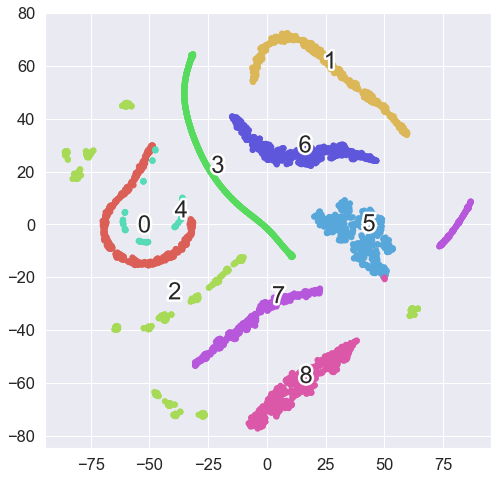

In [7]:
X=output.cpu()
y = np.array([g.label for g in graphs])
############################################################
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=0).fit_transform(X)
fashion_scatter(fashion_tsne, y)

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
import networkx as nx
from scipy import linalg
## Coming from https://github.com/mseitzer/pytorch-fid
def compute_FID(mu1, mu2, cov1, cov2, eps = 1e-6):
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert cov1.shape == cov2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(cov1.shape[0]) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(cov1) +
            np.trace(cov2) - 2 * tr_covmean)

def compute_fid(ref_graph,pred_graph,model):
    device = 0
    
    with torch.no_grad():
        embed_graphs_ref = model.get_graph_embed_sum(ref_graph)
        embed_graphs_ref=embed_graphs_ref.cpu().detach().numpy()
        mu_ref = np.mean(embed_graphs_ref, axis = 0)
        cov_ref = np.cov(embed_graphs_ref, rowvar = False)

        embed_graphs_pred = model.get_graph_embed_sum(pred_graph)
        embed_graphs_pred=embed_graphs_pred.cpu().detach().numpy()
        mu_pred = np.mean(embed_graphs_pred, axis = 0)
        cov_pred = np.cov(embed_graphs_pred, rowvar = False)

        fid = compute_FID(mu_ref,mu_pred,cov_ref,cov_pred)
        prdc = compute_prdc(real_features=embed_graphs_ref,
                           fake_features=embed_graphs_pred,
                           nearest_k=5)
        #kd,std = kernel_classifier_distance_and_std_from_activations(real_activations=embed_graphs_ref,generated_activations=embed_graphs_pred,dtype="float32")
    return fid ,prdc

def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = correct / float(len(train_graphs))


    #print("accuracy : %f" % (acc))

    return acc

In [13]:

def get_fid(filename,label,model):
    graph_gen = load_graph_list(filename,False)
    g_list,_=load_graph_asS2Vgraph(graph_gen,label,random,tagset,lentagset,onehot=onehot)
    fid,prdc=compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==label],g_list,model)
    print(filename+" fid : ",fid)
    print(filename+" GIN accuracy : ",test_acc(model,device,g_list))
    print(filename+" prdc : ", prdc)

    return fid,prdc

def get_fid_synth(graph,label,model):
    g_list,_=load_graph_asS2Vgraph(graph,label,random,tagset,lentagset,onehot=onehot)
    fid,prdc=compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==label],g_list,model)
    print(" fid : ",fid)
    print(" GIN accuracy : ",test_acc(model,device,g_list))
    print(" prdc : ", prdc)

    return fid,prdc

In [1]:
# Grid graph

get_fid('../../generated_graphs/grid_GRANMixtureBernoulli_DFS.p',4,model)
get_fid('../../generated_graphs/grid_RNN_BFS.p',4,model)
get_fid('../../generated_graphs/grid_RNN_MLP_BFS.p',4,model)

NameError: name 'get_fid' is not defined

In [ ]:
def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G
#barabasi
graph=[]
for i in range(100,200):
    for j in range(5):
        graph.append(nx.barabasi_albert_graph(i,4))
get_fid_synth(graph,1,model)
#watts
graph=[]
for i in range(100,200):
    for j in range(5):
        graph.append(nx.watts_strogatz_graph(i,4,0.1))
get_fid_synth(graph,0,model)
#com2
graph=[]
for k in range(100, 200):
    for j in range(5):
        c_sizes = np.random.choice(list(range(6, 10)), 2)
        g = n_community(c_sizes, p_inter=0.005)
        graph.append(g)
get_fid_synth(graph,2,model)

In [ ]:
#Barabasi
get_fid('../../generated_graphs/barabasi_GRANMixtureBernoulli_BFS.p',1,model)
get_fid('../../generated_graphs/barabasi_GRANMixtureBernoulli_DFS.p',1,model)
get_fid('../../generated_graphs/barabasi_GRANMixtureBernoulli_degree_decent.p',1,model)
get_fid('../../generated_graphs/barabasi_GRANMixtureBernoulli_k_core.p',1,model)
get_fid('../../generated_graphs/barabasi_GRANMixtureBernoulli_no_order.p',1,model)

get_fid('../../generated_graphs/barabasi_RNN_BFS.p',1,model)
get_fid('../../generated_graphs/barabasi_RNN_BFSMAX.p',1,model)
get_fid('../../generated_graphs/barabasi_RNN_DFS.p',1,model)
get_fid('../../generated_graphs/barabasi_RNN_nobfs.p',1,model)

In [ ]:
#watts

get_fid('../../generated_graphs/wattsSW_GRANMixtureBernoulli_BFS.p',0,model)
get_fid('../../generated_graphs/wattsSW_GRANMixtureBernoulli_DFS.p',0,model)
get_fid('../../generated_graphs/wattsSW_GRANMixtureBernoulli_degree_descent.p',0,model)
get_fid('../../generated_graphs/wattsSW_GRANMixtureBernoulli_k_core.p',0,model)
get_fid('../../generated_graphs/wattsSW_GRANMixtureBernoulli_no_order.p',0,model)

get_fid('../../generated_graphs/wattsSW_RNN_BFS.p',0,model)
get_fid('../../generated_graphs/wattsSW_RNN_BFSMAX.p',0,model)
get_fid('../../generated_graphs/wattsSW_RNN_DFS.p',0,model)
get_fid('../../generated_graphs/wattsSW_RNN_nobfs.p',0,model)

In [ ]:
#community2

get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_BFS.p',2,model)
get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_DFS.p',2,model)
get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_degree_decent.p',2,model)
get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_k_core.p',2,model)
get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_degree_accent.p',2,model)
get_fid('../../generated_graphs/community2small_GRANMixtureBernoulli_None.p',2,model)

get_fid('../../generated_graphs/community2small_RNN_BFS.p',2,model)
get_fid('../../generated_graphs/community2small_RNN_BFSMAX.p',2,model)
get_fid('../../generated_graphs/community2small_RNN_DFS.p',2,model)
get_fid('../../generated_graphs/community2small_RNN_nobfs.p',2,model)

In [ ]:
def test_acc(model, device, train_graphs):
    model.eval()

    output = pass_data_iteratively(model, train_graphs)
    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in train_graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()
    acc = float(correct / float(len(train_graphs)))


    print("accuracy : %f" % (acc))

    return acc

def n_community(c_sizes, p_inter=0.01):
    graphs = [nx.gnp_random_graph(c_sizes[i], 0.7, seed=i) for i in range(len(c_sizes))]
    G = nx.disjoint_union_all(graphs)
    communities = [G.subgraph(c) for c in nx.connected_components(G)]
    for i in range(len(communities)):
        subG1 = communities[i]
        nodes1 = list(subG1.nodes())
        for j in range(i + 1, len(communities)):
            subG2 = communities[j]
            nodes2 = list(subG2.nodes())
            has_inter_edge = False
            for n1 in nodes1:
                for n2 in nodes2:
                    if np.random.rand() < p_inter:
                        G.add_edge(n1, n2)
                        has_inter_edge = True
            if not has_inter_edge:
                G.add_edge(nodes1[0], nodes2[0])
    # print('connected comp: ', len(list(nx.connected_component_subgraphs(G))))
    return G

test_acc(model,'cuda:0',g_list_pred_rnn)

## Perturbation Test

In [ ]:
def perturb_new(graph_list, p):
    ''' Perturb the list of graphs by adding/removing edges.
    Args:
        p_add: probability of adding edges. If None, estimate it according to graph density,
            such that the expected number of added edges is equal to that of deleted edges.
        p_del: probability of removing edges
    Returns:
        A list of graphs that are perturbed from the original graphs
    '''
    perturbed_graph_list = []
    for G_original in graph_list:
        G = G_original.copy()
        edge_remove_count = 0
        for (u, v) in list(G.edges()):
            if np.random.rand()<p:
                G.remove_edge(u, v)
                edge_remove_count += 1
        # randomly add the edges back
        for i in range(edge_remove_count):
            while True:
                u = np.random.randint(0, G.number_of_nodes())
                v = np.random.randint(0, G.number_of_nodes())
                if (not G.has_edge(u,v)) and (u!=v):
                    break
            G.add_edge(u, v)
        perturbed_graph_list.append(G)
    return perturbed_graph_list

graph_ba_regen=[]
for i in range(100,200):
    for j in range(5):
        g=nx.watts_strogatz_graph(i,4,0.1)
        graph_ba_regen.append(g)
g_list_ref_ba_regen0,_ = load_graph_asS2Vgraph(graph_ba_regen,1,random, tagset , lentagset)
g_list_ref_ba_regen10,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.1),1,random, tagset , lentagset)
g_list_ref_ba_regen20,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.2),1,random, tagset , lentagset)
g_list_ref_ba_regen30,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.3),1,random, tagset , lentagset)
g_list_ref_ba_regen40,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.4),1,random, tagset , lentagset)
g_list_ref_ba_regen50,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.5),1,random, tagset , lentagset)
g_list_ref_ba_regen60,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.6),1,random, tagset , lentagset)
g_list_ref_ba_regen70,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.7),1,random, tagset , lentagset)

In [ ]:

g_list_ref_ba_regen80,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.8),1,random, tagset , lentagset)
g_list_ref_ba_regen90,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,0.9),1,random, tagset , lentagset)
g_list_ref_ba_regen100,_ = load_graph_asS2Vgraph(perturb_new(graph_ba_regen,1.0),1,random, tagset , lentagset)



In [ ]:
fids1=[]
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen0,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen10,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen20,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen30,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen40,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen50,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen70,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen80,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen90,model))
fids1.append(compute_fid([graphs[i] for i in range(len(graphs)) if graphs[i].label ==0],g_list_ref_ba_regen100,model))




In [ ]:

import matplotlib.pyplot as plt
perturb = np.arange(0,1,0.1)
plt.figure(figsize=(10,7))
plt.xlabel("Noise perturbation")
plt.ylabel("Fréchet Distance to the ref graph")
#
plt.plot(perturb,fids1,label='watts')
plt.draw()
plt.legend()